In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from sklearn.cluster import KMeans as skKM
from km import Kmeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
from cw2_utils import load_cw2_data, get_features
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [4]:
train_set, test_set, train_labels, test_labels = load_cw2_data()
features = get_features()

train_mean = np.mean(train_set, axis = 0)
train_std = np.std(train_set, axis = 0)
normalised_train_set = (train_set - train_mean) / train_std
normalised_test_set = (test_set - train_mean) / train_std

# normalised_train_set = preprocessing.normalize(train_set, norm='l2')
# normalised_test_set = preprocessing.normalize(test_set, norm='l2')

# print(train_set.shape, test_set.shape)
# for m, s, f in zip(train_mean, train_std, features):
#     print('{} - mean: {:.5}, std: {:.5}'.format(f, m, s))

(118, 2)


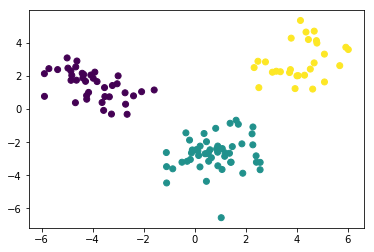

1.0
0.866666666667


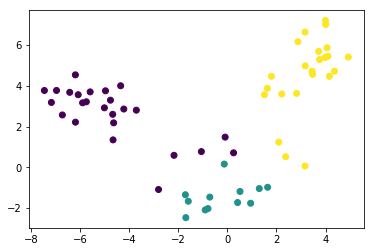

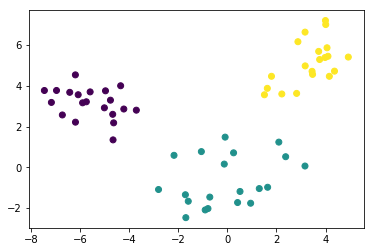

In [5]:
lda = LinearDiscriminantAnalysis()
projected_train = lda.fit_transform(train_set, train_labels)
projected_test = lda.transform(test_set)
print(projected_train.shape)
plt.scatter(projected_train[:, 0], projected_train[:, 1], c = train_labels)
plt.show()
nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(projected_train[:, :2], train_labels)
print(np.mean(nn.predict(projected_train) == train_labels))
print(np.mean(nn.predict(projected_test) == test_labels))

plt.scatter(projected_test[:, 0], projected_test[:, 1], c = nn.predict(projected_test))
plt.show()

plt.scatter(projected_test[:, 0], projected_test[:, 1], c = test_labels)
plt.show()

In [6]:
eps = 1e-10

def rootchi2(p, q):
    return np.sqrt(0.5 * np.sum((p - q) ** 2 / (p + q + eps)))

def rootJSDiv(p, q):
    return np.sqrt(
               0.5 * np.sum(p * np.log(2 * p / (p + q + eps))) + \
               0.5 * np.sum(q * np.log(2 * q / (p + q + eps)))
           )

distance_metrics = [
    'l1', 'l2', 'chebyshev',
    'cosine', 'mahalanobis', 
    rootchi2, # rootJSDiv,
]

neighbors = 1

In [7]:
km = Kmeans(train_set, k = 3, metric="euclidean")


kmeans: X (30, 13)  centres (3, 13)  delta=0.001  maxiter=10  metric=euclidean
kmeans: 8 iterations  cluster sizes: [ 8 15  7]
kmeans: X (118, 13)  centres (3, 13)  delta=0.001  maxiter=10  metric=euclidean
kmeans: 3 iterations  cluster sizes: [43 47 28]


In [8]:
print('############## NOT NORMALISED ######################')
km = KMeans(n_clusters=3, n_init = 100, algorithm = 'elkan')
km.fit(train_set)
transformed_train_set = km.transform(train_set)
transformed_test_set = km.transform(test_set)

metric_args = [
    ({},{}), ({},{}), ({},{}), 
    ({},{}), ({'V': np.cov(transformed_train_set.T)}, {'V': np.cov(train_set.T)}),
    ({},{}), #({},{}),
]

for dm, args in zip(distance_metrics, metric_args):

    nn = KNeighborsClassifier(n_neighbors=neighbors, metric=dm, metric_params=args[0])
    nn.fit(transformed_train_set, train_labels)
    print('{} - kmeans + nn: {:.4}'.format(dm, np.mean(nn.predict(transformed_test_set) == test_labels)))

    nn = KNeighborsClassifier(n_neighbors=neighbors, metric=dm, metric_params=args[1])
    nn.fit(train_set, train_labels)
    print('{} - nn: {:.4}\n'.format(dm, np.mean(nn.predict(test_set) == test_labels)))

############## NOT NORMALISED ######################


NameError: name 'KMeans' is not defined

In [39]:
print('############## NORMALISED ######################')
km = KMeans(n_clusters=3, n_init = 100, algorithm = 'elkan')
km.fit(normalised_train_set)
transformed_train_set = km.transform(normalised_train_set)
transformed_test_set = km.transform(normalised_test_set)


metric_args = [
    ({},{}), ({},{}), ({},{}), 
    ({},{}), ({'V': np.cov(transformed_train_set.T)}, {'V': np.cov(normalised_train_set.T)}),
    ({},{}), #({},{}),
]

for dm, args in zip(distance_metrics, metric_args):

    nn = KNeighborsClassifier(n_neighbors=neighbors, metric=dm, metric_params=args[0])
    nn.fit(transformed_train_set, train_labels)
    print('{} - kmeans + nn: {:.4}'.format(dm, np.mean(nn.predict(transformed_test_set) == test_labels)))

    nn = KNeighborsClassifier(n_neighbors=neighbors, metric=dm, metric_params=args[1])
    nn.fit(normalised_train_set, train_labels)
    print('{} - nn: {:.4}\n'.format(dm, np.mean(nn.predict(normalised_test_set) == test_labels)))

############## NORMALISED ######################
l1 - kmeans + nn: 0.9333
l1 - nn: 0.9167

l2 - kmeans + nn: 0.9167
l2 - nn: 0.9

chebyshev - kmeans + nn: 0.9167
chebyshev - nn: 0.8833

cosine - kmeans + nn: 0.9167
cosine - nn: 0.9167

mahalanobis - kmeans + nn: 0.9
mahalanobis - nn: 0.8833

<function rootchi2 at 0x000002D992E2BA60> - kmeans + nn: 0.9167
<function rootchi2 at 0x000002D992E2BA60> - nn: 0.7167



c:\users\rameg\miniconda2\envs\patternrec\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


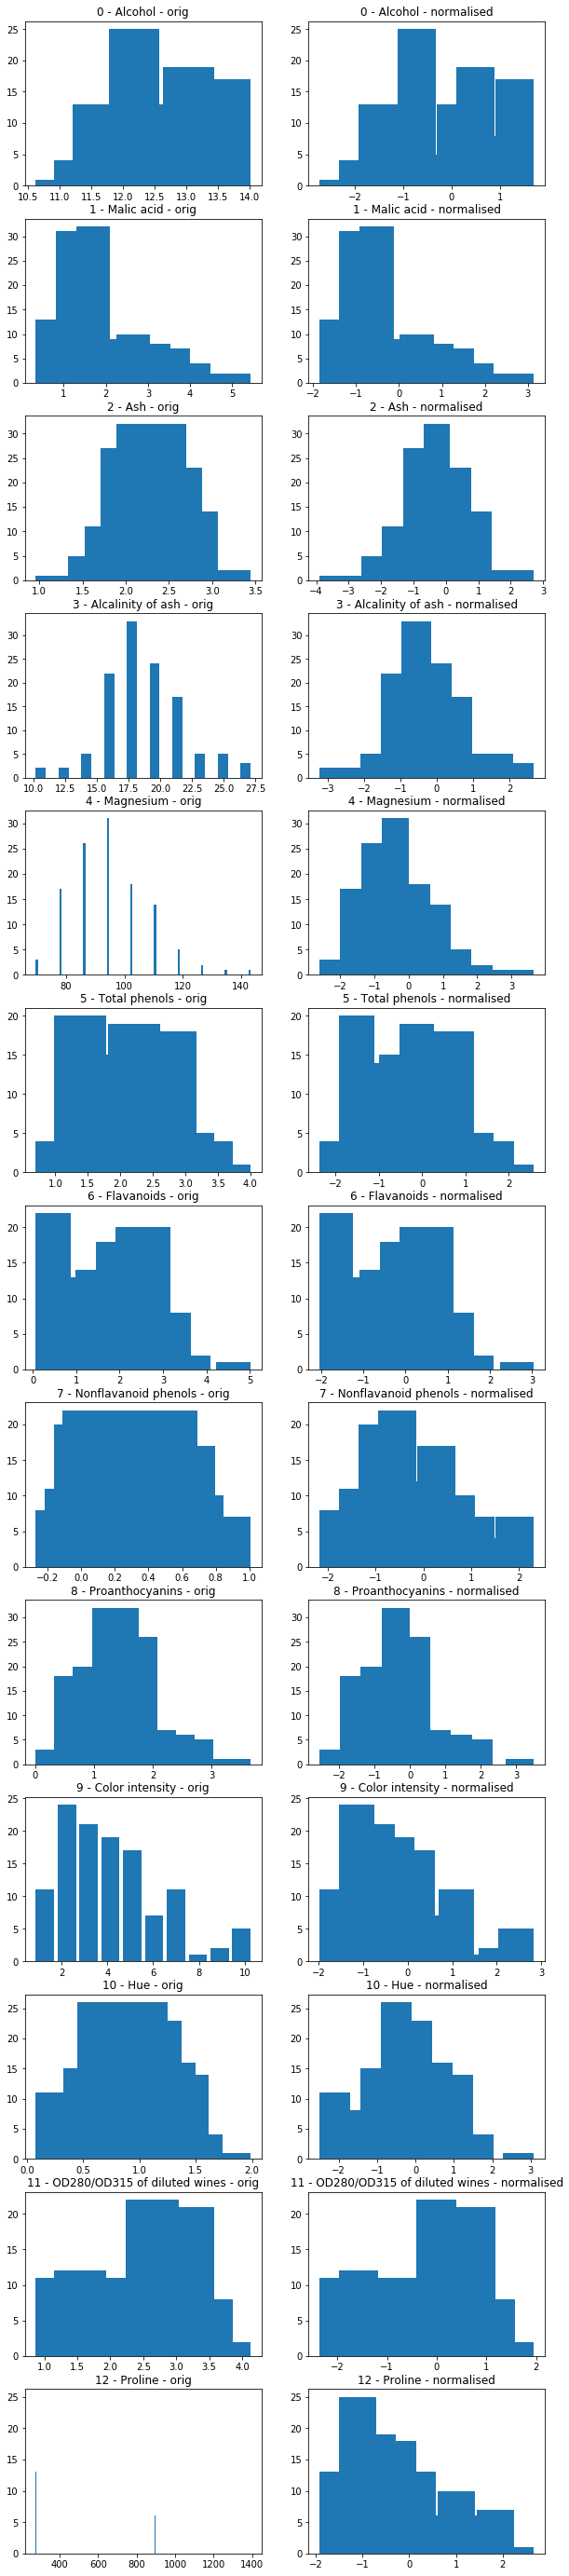

In [156]:
histograms = []
f, axes = plt.subplots(13, 2, figsize = (10, 50))
for feature_id in range(train_set.shape[1]):
    hist, bins = np.histogram(train_set[:, feature_id], bins = int(sqrt(train_set.shape[0])))
    histograms.append((hist, bins))
    axes[feature_id][0].bar(bins[:-1], hist)
    axes[feature_id][0].set_title('{} - {} - orig'.format(feature_id, features[feature_id]))
    
    hist, bins = np.histogram(normalised_train_set[:, feature_id], bins = int(sqrt(normalised_train_set.shape[0])))
    histograms.append((hist, bins))
    axes[feature_id][1].bar(bins[:-1], hist)
    axes[feature_id][1].set_title('{} - {} - normalised'.format(feature_id, features[feature_id]))

In [10]:
from sklearn.neural_network import MLPClassifier

c:\users\rameg\miniconda2\envs\patternrec\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


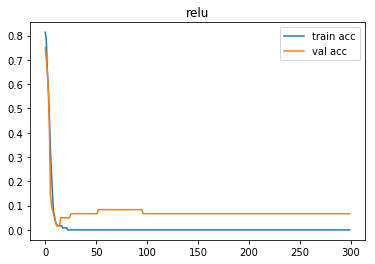

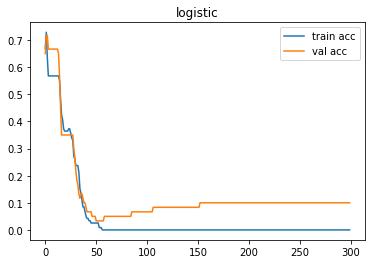

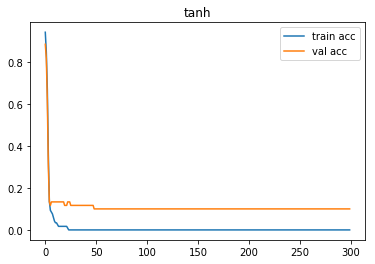

In [11]:
activation = ['relu', 'logistic', 'tanh']
for act in activation:
    mlp = MLPClassifier(
        hidden_layer_sizes = (100,),
        learning_rate_init=0.01, 
        learning_rate='adaptive', warm_start=True, 
        solver='sgd', max_iter = 1, verbose = False,
        activation=act
    )
    train_acc = []
    val_acc = []
    iters = range(300)
    for _ in iters:
        mlp.fit(normalised_train_set, train_labels)
        train_acc.append(mlp.score(normalised_train_set, train_labels))
        val_acc.append(mlp.score(normalised_test_set, test_labels))

    plt.plot(iters, 1 - np.asarray(train_acc))
    plt.plot(iters, 1 - np.asarray(val_acc))
    plt.legend(['train acc', 'val acc'])
    plt.title(act)
    plt.show()

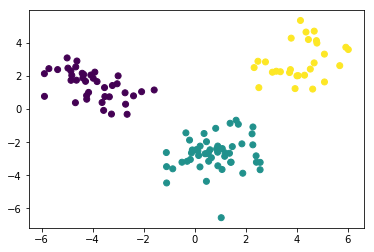

In [16]:
lda = LinearDiscriminantAnalysis()
projected_train = lda.fit_transform(normalised_train_set, train_labels)
projected_test = lda.transform(normalised_test_set)
plt.scatter(projected_train[:, 0], projected_train[:, 1], c = train_labels)
plt.show()

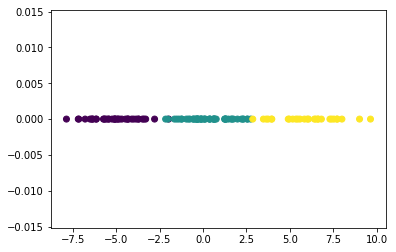

In [20]:
mlp = MLPClassifier(
        hidden_layer_sizes = (1,),
        learning_rate_init=0.01, 
        learning_rate='adaptive', warm_start=True, 
        solver='sgd', max_iter = 1000, verbose = False,
        activation='identity'
    )

mlp.fit(normalised_train_set, train_labels)

weights = np.asarray(mlp.coefs_)
bias = np.asarray(mlp.intercepts_)

hidden_activation = (np.dot(normalised_train_set, weights[0]) + bias[0]).ravel()
plt.scatter(hidden_activation, np.zeros_like(hidden_activation), c = train_labels)


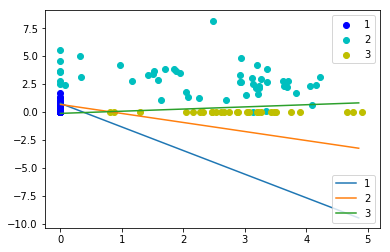

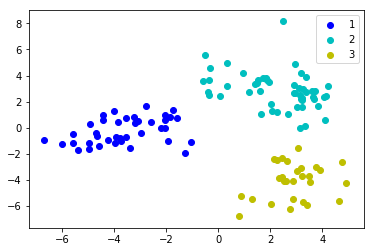

In [22]:
mlp = MLPClassifier(
        hidden_layer_sizes = (2,),
        learning_rate_init=0.01, 
        learning_rate='adaptive', warm_start=True, 
        solver='sgd', max_iter = 2000, verbose = False,
        activation='identity'
    )

mlp.fit(normalised_train_set, train_labels)
weights = np.asarray(mlp.coefs_)
bias = np.asarray(mlp.intercepts_)

hidden_activation = np.dot(normalised_train_set, weights[0]) + bias[0]
colors = ['b', 'c', 'y']
scatters = [
    plt.scatter(
        hidden_activation[train_labels == int(c), 0], 
        hidden_activation[train_labels == int(c), 1], 
        color = colors[int(c) - 1]
    )
    for c in mlp.classes_
]

l1 = plt.legend(scatters, [str(int(c)) for c in mlp.classes_], loc = 1)

minh1 = min(hidden_activation[:, 0])
maxh1 = max(hidden_activation[:, 0])
minh2 = min(hidden_activation[:, 1])
maxh2 = max(hidden_activation[:, 1])

c_weights = weights[1]
c_bias = bias[1]

for i in range(len(mlp.classes_)):
    h1 = np.arange(minh1, maxh1, (maxh1 - minh1) / 100)
    plt.plot(h1, (- c_bias[i] - h1 * c_weights[0, i]) / c_weights[1, i])
    
plt.legend([str(int(c)) for c in mlp.classes_], loc = 4)
plt.gca().add_artist(l1)
plt.show()


hidden_activation = np.dot(normalised_train_set, weights[0]) + bias[0]

colors = ['b', 'c', 'y']
scatters = [
    plt.scatter(
        hidden_activation[train_labels == int(c), 0], 
        hidden_activation[train_labels == int(c), 1], 
        color = colors[int(c) - 1]
    )
    for c in mlp.classes_
]
plt.legend(scatters, [str(int(c)) for c in mlp.classes_])
plt.show()